In [1]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sowmi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sowmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sowmi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sowmi\AppData\Roaming\nltk_data...


Importing the dataset

In [2]:
dataset= pd.read_csv('Dataset-SA.csv')

In [39]:
last_col=dataset.iloc[:,-1]
last_col.value_counts()


Sentiment
positive    166581
negative     28232
neutral      10239
Name: count, dtype: int64

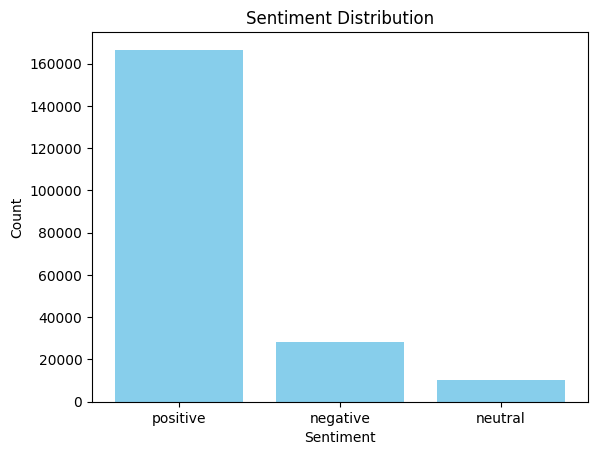

In [43]:
import matplotlib.pyplot as plt
X_axis=['positive', 'negative', 'neutral']
Y_axis=last_col.value_counts().tolist()

plt.bar(X_axis, Y_axis, color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205052 non-null  object
 1   product_price  205052 non-null  object
 2   Rate           205052 non-null  object
 3   Review         180388 non-null  object
 4   Summary        205041 non-null  object
 5   Sentiment      205052 non-null  object
dtypes: object(6)
memory usage: 9.4+ MB


Checking for missing values

In [5]:
print(dataset.isnull().sum())

print('Shape: ', dataset.shape)

product_name         0
product_price        0
Rate                 0
Review           24664
Summary             11
Sentiment            0
dtype: int64
Shape:  (205052, 6)


In [6]:
dataset.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [7]:
data = dataset.drop(['product_name','product_price','Rate'], axis=1) #removing the columns we don't need

In [8]:
data.head()

,Review,Summary,Sentiment
0,super!,great cooler excellent air flow and for this p...,positive
1,awesome,best budget 2 fit cooler nice cooling,positive
2,fair,the quality is good but the power of air is de...,positive
3,useless product,very bad product its a only a fan,negative
4,fair,ok ok product,neutral


In [9]:
data.dropna(inplace=True, axis=0)
print(data.shape)
print(data.isnull().sum())

(180379, 3)
Review       0
Summary      0
Sentiment    0
dtype: int64


In [10]:
data['Review'].value_counts() #distribution of data

Review
wonderful                    9014
not specified                8351
brilliant                    5643
awesome                      5636
great product                5621
                             ... 
good 360 rotation product       1
amazing camera                  1
ptz camera                      1
good camera from qubo           1
regular usage not good.         1
Name: count, Length: 1324, dtype: int64

In [11]:
data= data[data['Review']!='not specified']

In [12]:
data= data[data['Review']!='pigeon favourite electric kettle??????(1.5 l, silver, black)']

In [13]:
data['Review'].value_counts()

Review
wonderful                          9014
brilliant                          5643
awesome                            5636
great product                      5621
classy product                     5602
                                   ... 
excellent and must buy                1
customer support not available.       1
awesomevery good                      1
hoping for the best                   1
smart kettle                          1
Name: count, Length: 1322, dtype: int64

Text Preprocessing

In [14]:

def clean_column(text):
    if text is not None:
        text= text.lower()
        text= re.sub(r'-|_','', text)
        text= re.sub(r"[^\w\s']|\n|[0-9]+",'',text)
        text= re.sub(r'<.*?>','',text)
    return text

data['Review']=data['Review'].apply(clean_column)
data['Summary']=data['Summary'].apply(clean_column)


In [15]:
data['Summary'].head(10)

0    great cooler excellent air flow and for this p...
1                 best budget  fit cooler nice cooling
2    the quality is good but the power of air is de...
3                    very bad product its a only a fan
4                                        ok ok product
5    the cooler is really fantastic and provides go...
6                                    very good product
7                                            very nice
8                                      very bad cooler
9                                            very good
Name: Summary, dtype: object

In [16]:
print((data['Review']=='').sum())
print((data['Summary']=='').sum())



4
0


In [17]:
data= data[data['Review']!='']

Vector conversion

In [18]:

def tokenizing_the_body(text):
    tokenized_text= word_tokenize(text)
    return tokenized_text
data['Review']=data['Review'].apply(tokenizing_the_body)
data['Summary']=data['Summary'].apply(tokenizing_the_body)

data.head()

,Review,Summary,Sentiment
0,[super],"[great, cooler, excellent, air, flow, and, for...",positive
1,[awesome],"[best, budget, fit, cooler, nice, cooling]",positive
2,[fair],"[the, quality, is, good, but, the, power, of, ...",positive
3,"[useless, product]","[very, bad, product, its, a, only, a, fan]",negative
4,[fair],"[ok, ok, product]",neutral


In [19]:

all_stop_words= set(stopwords.words('english'))
all_stop_words.remove('not')
def stop_word_remover(tokens):
    filtered_token=[]
    for word in tokens:
        if word not in all_stop_words and len(word)>1:
            filtered_token.append(word)
    return filtered_token

data['Review']= data['Review'].apply(stop_word_remover)
data['Summary']= data['Summary'].apply(stop_word_remover)



In [20]:
data.head()

,Review,Summary,Sentiment
0,[super],"[great, cooler, excellent, air, flow, price, a...",positive
1,[awesome],"[best, budget, fit, cooler, nice, cooling]",positive
2,[fair],"[quality, good, power, air, decent]",positive
3,"[useless, product]","[bad, product, fan]",negative
4,[fair],"[ok, ok, product]",neutral


Lemmatisation


In [21]:


lemmatizer = WordNetLemmatizer()

def get_pos(tag):

    tag = tag[0].upper()
    if tag == 'J':
        return wordnet.ADJ
    elif tag == 'N':
        return wordnet.NOUN
    elif tag == 'R':
        return wordnet.ADV
    elif tag == 'V':
        return wordnet.VERB
    else:
        return wordnet.NOUN
def lemma_finder(token_list):

    if not token_list:
        return []

    tagged_tokens = pos_tag(token_list)

    lemmatized_tokens = []
    for word, tag in tagged_tokens:
        wn_tag = get_pos(tag)
        lemma = lemmatizer.lemmatize(word, pos=wn_tag)
        lemmatized_tokens.append(lemma)

    return lemmatized_tokens

data['Summary'] = data['Summary'].apply(lemma_finder)
data['Review'] = data['Review'].apply(lemma_finder)




In [22]:
data.head()

,Review,Summary,Sentiment
0,[super],"[great, cooler, excellent, air, flow, price, a...",positive
1,[awesome],"[best, budget, fit, cooler, nice, cooling]",positive
2,[fair],"[quality, good, power, air, decent]",positive
3,"[useless, product]","[bad, product, fan]",negative
4,[fair],"[ok, ok, product]",neutral


In [ ]:

le= LabelEncoder() 
data['Sentiment'] = le.fit_transform(data['Sentiment']) #encoding the sentiment column
data.head()

,Review,Summary,Sentiment
0,[super],"[great, cooler, excellent, air, flow, price, a...",2
1,[awesome],"[best, budget, fit, cooler, nice, cooling]",2
2,[fair],"[quality, good, power, air, decent]",2
3,"[useless, product]","[bad, product, fan]",0
4,[fair],"[ok, ok, product]",1


In [24]:
import numpy as np
import pandas as pd



data['Review_concat'] = data['Review'].apply(lambda tokens: ' '.join(tokens))
data['Summary_concat'] = data['Summary'].apply(lambda tokens: ' '.join(tokens))


tf_review = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
x1 = tf_review.fit_transform(data['Review_concat'])

tf_summary = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
x2 = tf_summary.fit_transform(data['Summary_concat'])

X = hstack([x1, x2])
y = data['Sentiment']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)




In [ ]:
accuraries=[]
models=['Naive Bayes', 'Linear SVC', 'Random Forest']

Training the model on Naive Bayes

In [53]:
# Train Multinomial Naive Bayes
nb_clf = MultinomialNB()
nb_clf.fit(xtrain, ytrain)
nb_pred = nb_clf.predict(xtest)

print("Multinomial Naive Bayes Results:")
print(classification_report(ytest, nb_pred))
print(confusion_matrix(ytest, nb_pred))
print("Accuracy:", accuracy_score(ytest, nb_pred))
accuraries.append(accuracy_score(ytest, nb_pred))


Multinomial Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      4646
           1       0.52      0.33      0.40      1661
           2       0.96      0.97      0.97     28098

    accuracy                           0.93     34405
   macro avg       0.77      0.73      0.74     34405
weighted avg       0.92      0.93      0.92     34405

[[ 4067   156   423]
 [  344   542   775]
 [  396   345 27357]]
Accuracy: 0.9291091411132103


Training the model on Linear SVC

In [54]:
# Train Linear SVC
svc_clf = LinearSVC(class_weight='balanced', random_state=42)
svc_clf.fit(xtrain, ytrain)
svc_pred = svc_clf.predict(xtest)

print("Linear SVC Results:")
print(classification_report(ytest, svc_pred))
print(confusion_matrix(ytest, svc_pred))
print("Accuracy:", accuracy_score(ytest, svc_pred))
accuraries.append(accuracy_score(ytest, svc_pred))
print("F1 Score:", f1_score(ytest, svc_pred, average='weighted'))


Linear SVC Results:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4646
           1       0.49      0.59      0.54      1661
           2       0.98      0.96      0.97     28098

    accuracy                           0.93     34405
   macro avg       0.78      0.82      0.80     34405
weighted avg       0.94      0.93      0.94     34405

[[ 4142   291   213]
 [  268   986   407]
 [  372   731 26995]]
Accuracy: 0.9336724313326551
F1 Score: 0.9360276221416235


Training the model on RandomForest

In [55]:


rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(xtrain, ytrain)
rf_pred = rf_clf.predict(xtest)

# Evaluation
print("Random Forest Results:")
print(classification_report(ytest, rf_pred))
print(confusion_matrix(ytest, rf_pred))
print("Accuracy:", accuracy_score(ytest, rf_pred))
accuraries.append(accuracy_score(ytest, rf_pred))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      4646
           1       0.27      0.59      0.37      1661
           2       0.98      0.90      0.94     28098

    accuracy                           0.88     34405
   macro avg       0.68      0.77      0.71     34405
weighted avg       0.92      0.88      0.89     34405

[[ 3836   623   187]
 [  316   977   368]
 [  729  1953 25416]]
Accuracy: 0.8786222932713268


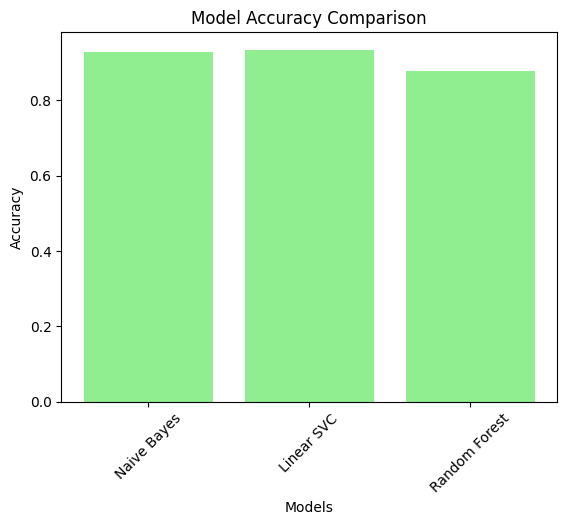

In [57]:
plt.bar(models, accuraries, color='lightgreen')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

Testing with custom input

In [31]:
def preprocess_input(summary, review):
    # Clean
    summary = clean_column(summary)
    review = clean_column(review)

    # Tokenize
    summary = word_tokenize(summary)
    review = word_tokenize(review)

    # Stopword removal
    summary = stop_word_remover(summary)
    review = stop_word_remover(review)

    # Lemmatize
    summary = lemma_finder(summary)
    review = lemma_finder(review)

    # Join for vectorization
    summary_str = ' '.join(summary)
    review_str = ' '.join(review)

    # Vectorize
    summary_vec = tf_summary.transform([summary_str])
    review_vec = tf_review.transform([review_str])

    return hstack([review_vec, summary_vec])


summary_input = input("Enter the review summary: ")
review_input = input("Enter the detailed review: ")


X_manual = preprocess_input(summary_input, review_input)


prediction = svc_clf.predict(X_manual)
sentiment = le.inverse_transform(prediction)[0]


def generate_reply(sentiment):
    if sentiment.lower() =='positive':
        return "Thank you for your valuable feedback! We're glad you liked the product. 😊"
    elif sentiment.lower() =='negative':
        return "We're really sorry to hear about your experience. Please contact our support so we can assist you further. 🙏"
    elif sentiment.lower() =='neutral':
        return "Thank you for your feedback. We'll strive to improve your experience next time. 👍"
    else:
        return "Thanks for your review!"


reply = generate_reply(sentiment)
print("\nAutomated Merchant Reply: ", reply)






Automated Merchant Reply:  Thank you for your valuable feedback! We're glad you liked the product. 😊
